In [1]:
import numpy as np
import pandas as pd
import _pickle as cPickle
import os
import torch
import seaborn as sns

from game import TinyHintGuessGame
from agent import QAgent

In [2]:
# append results to list

model_name = 'ActionIn-one_hot-1-15-3'

res_list = []
for res_folder in sorted(list(os.walk('../res'))[0][1]):
    if res_folder.startswith(model_name):
        try:
            with open(f'../res/{res_folder}/1000000.pkl', 'rb') as fp: 
                res = cPickle.load(fp)
                res_list.append(res)
        except FileNotFoundError:
                print(f"no pickle found for {res_folder}!")
print(f'file loaded! model count: {len(res_list)}')

file loaded! model count: 15


In [3]:
res_list = res_list[:15]

In [4]:
def sample_games(hinter, guesser, samples=100, print_games=False, env=None):
    r_list = []
    if not env:
        env = hinter.env
    for _ in range(samples):
        obs_to_hinter = env.reset()
        hint_action = hinter.select_action(torch.tensor(obs_to_hinter, device=hinter.device))
        obs_to_guesser, _, _, _ = env.step(hint_action.item())
        guess_action = guesser.select_action(torch.tensor(obs_to_guesser, device=hinter.device))
        _, r, _, _ = env.step(guess_action)
        r_list += [r]
        if print_games:
            print(env.h1, env.h2, "target:", env.target, "hint", env.hint, "guess", env.guess, r)
    r_list = np.array(r_list)
    return np.sum(np.array(r_list) >= 0, axis=0) / r_list.shape[0]
    
def cross_play(res_list, samples=100):
    group_size = len(res_list)
    score_array = np.zeros((group_size, group_size))
    for i in range(group_size):
        for j in range(group_size):
            p1 = res_list[i]['p1']
            p2 = res_list[j]['p2']
            score_array[i][j] = sample_games(p1, p2, samples = samples)
            print(i, j, "score:", score_array[i][j])
    return score_array

In [5]:
# %%time
score_array = cross_play(res_list, samples=100)

0 0 score: 0.59
0 1 score: 0.31
0 2 score: 0.4
0 3 score: 0.38
0 4 score: 0.38
0 5 score: 0.41
0 6 score: 0.42
0 7 score: 0.32
0 8 score: 0.39
0 9 score: 0.36
0 10 score: 0.33
0 11 score: 0.38
0 12 score: 0.41
0 13 score: 0.42
0 14 score: 0.44
1 0 score: 0.38
1 1 score: 0.72
1 2 score: 0.37
1 3 score: 0.41
1 4 score: 0.45
1 5 score: 0.32
1 6 score: 0.34
1 7 score: 0.25
1 8 score: 0.3
1 9 score: 0.36
1 10 score: 0.39
1 11 score: 0.37
1 12 score: 0.37
1 13 score: 0.33
1 14 score: 0.46
2 0 score: 0.34
2 1 score: 0.4
2 2 score: 0.52
2 3 score: 0.47
2 4 score: 0.42
2 5 score: 0.38
2 6 score: 0.34
2 7 score: 0.36
2 8 score: 0.37
2 9 score: 0.33
2 10 score: 0.53
2 11 score: 0.32
2 12 score: 0.37
2 13 score: 0.38
2 14 score: 0.33
3 0 score: 0.37
3 1 score: 0.46
3 2 score: 0.41
3 3 score: 0.65
3 4 score: 0.34
3 5 score: 0.34
3 6 score: 0.31
3 7 score: 0.44
3 8 score: 0.45
3 9 score: 0.39
3 10 score: 0.44
3 11 score: 0.41
3 12 score: 0.37
3 13 score: 0.37
3 14 score: 0.34
4 0 score: 0.41
4 1 sco

In [11]:
np.savetxt(f"../{model_name}.csv", score_array, delimiter=",")

In [89]:
print('sp', np.diagonal(score_array).mean(), 'sde', np.diagonal(score_array).std() / np.sqrt(score_array.shape[0]) )

sp 0.7353846153846153 sde 0.014209563602366049


In [90]:
off_diag_scores = np.ma.array(score_array, mask=False)
off_diag_scores.mask[np.diag_indices(score_array.shape[0])] = True
print('xp', off_diag_scores.mean(), 'sde', off_diag_scores.std() / np.sqrt(off_diag_scores.shape[0] * (off_diag_scores.shape[0]-1) ))

xp 0.45711538461538465 sde 0.021457802575804163


<AxesSubplot:>

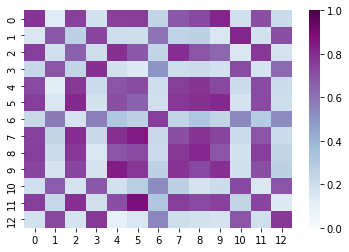

In [91]:
sns.heatmap(score_array, cmap="BuPu", vmin=0, vmax=1)

In [95]:
sample_games(res_list[0]['p1'], res_list[0]['p2'], samples=20, print_games=True)

[ 4 12  5] [ 6 13 11] target: 6 hint 12 guess 6 10.0
[ 6 10 13] [4 4 5] target: 4 hint 13 guess 4 10.0
[ 7  2 11] [ 2 10  8] target: 10 hint 2 guess 10 10.0
[12  0 10] [0 8 5] target: 8 hint 0 guess 8 10.0
[ 8 13  8] [11  9  9] target: 9 hint 13 guess 11 -10.0
[14 10  8] [ 1  4 12] target: 12 hint 8 guess 12 10.0
[ 0 10  9] [8 1 7] target: 7 hint 9 guess 7 10.0
[12 10  8] [1 2 3] target: 3 hint 8 guess 3 10.0
[ 6 12 13] [5 1 8] target: 8 hint 6 guess 8 10.0
[10  8  0] [ 6 11  2] target: 11 hint 0 guess 11 10.0
[11 14 11] [11  7 12] target: 11 hint 11 guess 11 10.0
[ 0 12 12] [2 7 5] target: 2 hint 12 guess 2 10.0
[ 4  3 10] [3 9 4] target: 3 hint 10 guess 3 10.0
[2 2 6] [14 14 12] target: 14 hint 2 guess 12 -10.0
[ 0  2 10] [ 0  0 10] target: 0 hint 10 guess 0 10.0
[10  1  4] [9 8 0] target: 0 hint 10 guess 0 10.0
[ 6  3 10] [13 10  3] target: 10 hint 6 guess 10 10.0
[ 6  0 14] [ 9 12 12] target: 12 hint 0 guess 12 10.0
[2 8 5] [ 6 14  6] target: 6 hint 5 guess 6 10.0
[ 5 10 14] [ 1 14

0.9